In [48]:
pip install matplotlib numpy numba

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time

In [43]:
image = plt.imread('src/photo2.jpg')
imageHeight, imageWidth, _ = image.shape
pixel_count = imageHeight * imageWidth

grayscale_cpu = np.zeros((imageHeight, imageWidth, 3), np.uint8)

In [44]:
@cuda.jit

def grayscale(src, dst):
    # where are we in the input?
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) // 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

In [57]:
blockSize = 64
gridSize = int(pixel_count / blockSize)
input = image.reshape((pixel_count, 3))
output = np.zeros((pixel_count, 3), np.uint8)

devSrc = cuda.to_device(input)
devDst = cuda.device_array((pixel_count, 3), np.uint8)

In [58]:
start_gpu = time.time()
grayscale[gridSize, blockSize](devSrc, devDst)
end_gpu = time.time()
print(f"Temps GPU : {end_gpu - start_gpu:.5f} secondes")

hostDst = devDst.copy_to_host().reshape((imageHeight, imageWidth, 3))

Temps GPU : 0.00052 secondes


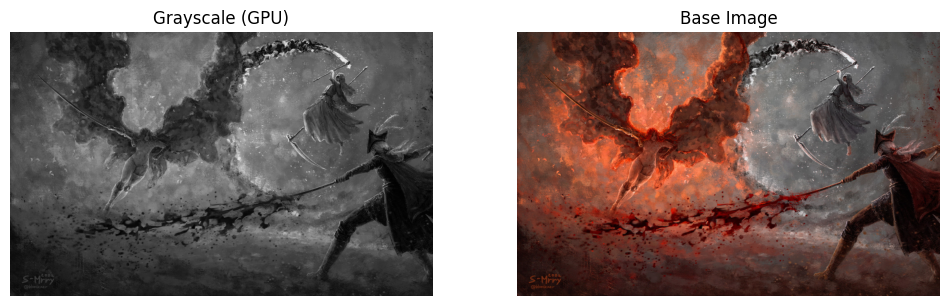

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(hostDst, cmap='gray')
ax[0].set_title("Grayscale (GPU)")
ax[0].axis('off')
ax[1].imshow(image)
ax[1].set_title("Base Image")
ax[1].axis('off')
plt.savefig('result/grayscale_gpu.png')
plt.show()

In [60]:
def rgb_to_gray_cpu(image):
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            grayscale_cpu[y, x] = np.mean(image[y, x])

In [72]:
start_cpu = time.time()
rgb_to_gray_cpu(image)
end_cpu = time.time()

print(f"CPU Time: {end_cpu - start_cpu:.5f} seconds")

CPU Time: 36.15424 seconds


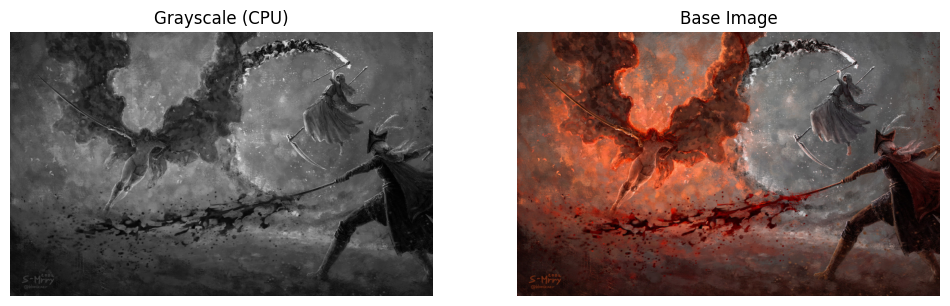

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(grayscale_cpu, cmap='gray')
ax[0].set_title("Grayscale (CPU)")
ax[0].axis('off')
ax[1].imshow(image)
ax[1].set_title("Base Image")
ax[1].axis('off')
plt.savefig('result/grayscale_cpu.png')
plt.show()

In [74]:
speedup = (end_cpu - start_cpu) / (end_gpu - start_gpu)
print(f"Speedup: {speedup:.0f}x")

Speedup: 69946x


In [70]:
def run_gpu_grayscale(block_size):
    grid_size = int(pixel_count / block_size)

    devSrc = cuda.to_device(input)
    devDst = cuda.device_array((pixel_count, 3), dtype=np.uint8)

    start_gpu = time.time()
    grayscale[grid_size, block_size](devSrc, devDst)
    cuda.synchronize()
    end_gpu = time.time()

    hostDst = devDst.copy_to_host().reshape((imageHeight, imageWidth, 3))
    return hostDst, end_gpu - start_gpu


Running with block size: 8
Execution time: 0.00222 seconds
Running with block size: 16
Execution time: 0.00124 seconds
Running with block size: 32
Execution time: 0.00072 seconds
Running with block size: 64
Execution time: 0.00037 seconds
Running with block size: 128
Execution time: 0.00034 seconds
Running with block size: 256
Execution time: 0.00033 seconds
Running with block size: 512
Execution time: 0.00035 seconds


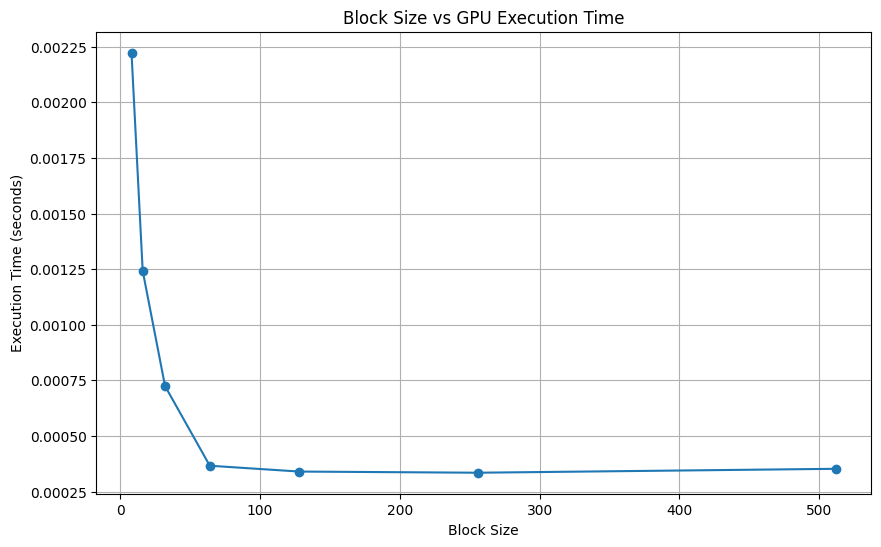

In [71]:
block_sizes = [8, 16, 32, 64, 128, 256, 512]
execution_times = []

for block_size in block_sizes:
    print(f"Running with block size: {block_size}")
    _, exec_time = run_gpu_grayscale(block_size)
    print(f"Execution time: {exec_time:.5f} seconds")
    execution_times.append(exec_time)

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, execution_times, marker='o')
plt.xlabel('Block Size')
plt.ylabel('Execution Time')
plt.title('Block Size vs GPU Execution Time')
plt.grid(True)
plt.show()